In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torchmetrics import MeanAbsolutePercentageError


from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config

from models.predictor import GRU
from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel

import copy

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_diff.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Diffusion_TS Model
diffusion_ts = instantiate_from_config(configs['model']).to(device)
batch_size = 128

In [3]:
# dataloader
dl_info = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)

dl = dl_info["dataloader"]
dataset = dl_info['dataset']

In [4]:
# trainer = Trainer(config_solver=configs["solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
# trainer.train_decomp(save_disc="model_diff")

In [5]:
diffusion_ts.load_state_dict(torch.load("check_points/stock/diff_23/model_diff_10000.pth"))


<All keys matched successfully>

In [6]:
fake_data = diffusion_ts.generate_mts(batch_size=3000)
np.save("output/fake_data_diff", fake_data)

reverse step from x_T to x_0:   0%|          | 0/100 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


In [7]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
gt_data = np.load(os.path.join(dataset.dir, f"stock_diff_data_{seq_length}_train.npy"))
idx = np.random.permutation(len(gt_data))[:3000]
ori_data = gt_data[idx]

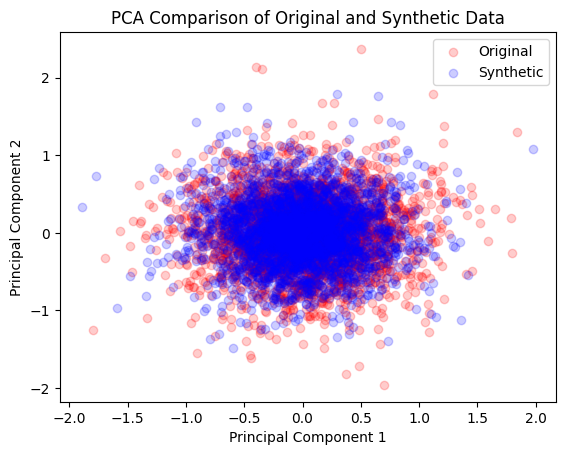

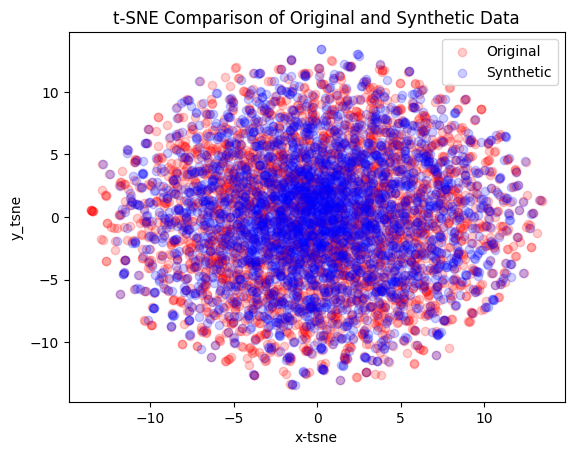

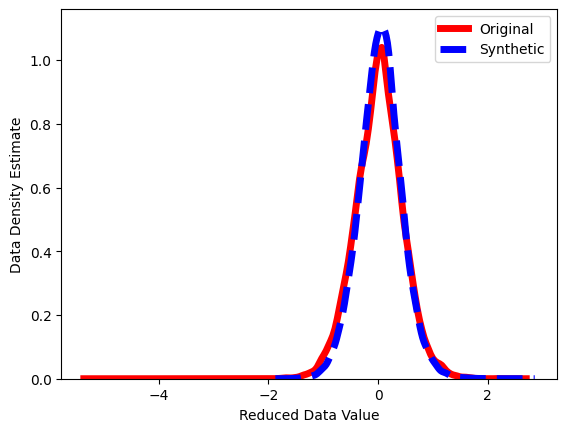

In [8]:
visualize_pca(ori_data, fake_data, 3000)
visualize_tsne(ori_data, fake_data, 3000)
visualize_kernel(ori_data, fake_data, 3000)

In [9]:
test_data_norm_origin = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_data_{seq_length}_test.npy"))).to(device)
test_data_diff = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_diff_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_std_{seq_length}_test.npy"))).to(device)

test_dataset = TensorDataset(test_data_diff, test_data_norm_origin, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()


In [10]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data in dataloader:
                x_train = data[:,:-1,:].float().to(device)
                y_train = data[:,-1:,0].float().to(device)
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [11]:
def evaluate_model(model, dataloader):
    model.eval()
    seq_length=23
    # define loss for comparison
    l1loss = nn.L1Loss()
    l2loss = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    
    total_l1 = 0
    total_l2 = 0

    predictions, true_vals = [], []
    with torch.no_grad():
        for data_diff, data_norm, data_mean, data_std  in dataloader:
            x_test = data_diff[:, :(seq_length - 1), :].float().to(device)
            y_test = data_diff[:, (seq_length - 1):, :1].float().to(device)
            y_pred = model(x_test).view(-1,1,1)
            y_pred_norm = data_norm[:,-2:-1,:1] + y_pred
            y_test_norm = data_norm[:,-2:-1,:1] + y_test
            
            y_pred_unnorm = y_pred_norm * data_std[:, :, :1] + data_mean[:, :, :1]
            y_test_unnorm = y_test_norm * data_std[:, :, :1] + data_mean[:, :, :1]
            total_l1 += l1loss(y_pred_unnorm, y_test_unnorm) * len(data_diff)
            total_l2 += l2loss(y_pred_unnorm, y_test_unnorm) * len(data_diff)
            # total_mape += mapeloss(y_pred_unnorm, y_test_unnorm).item() * len(data_diff)

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    n_data = len(dataloader.dataset)
    total_l1 /= n_data
    total_l2 /= n_data
    # total_mape /= n_data
    
    predictions = np.concatenate(predictions).squeeze()
    true_vals = np.concatenate(true_vals).squeeze()
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_l1, total_l2, mape_loss, predictions, true_vals

In [12]:
gt_predictor = GRU(5, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)

train_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, num_epochs=3000)


 loss: 0.020137: 100%|██████████| 3000/3000 [01:15<00:00, 39.98it/s]


In [13]:
train_data_norm_origin = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_data_{seq_length}_train.npy"))).to(device)
train_data_diff = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_diff_data_{seq_length}_train.npy"))).to(device)
train_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_mean_{seq_length}_train.npy"))).to(device)
train_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_origin_std_{seq_length}_train.npy"))).to(device)

train_dataset = TensorDataset(train_data_diff, train_data_norm_origin, train_mean, train_std)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lossfn = nn.L1Loss()
# lossfn = nn.MSELoss()


In [14]:
l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, train_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


Adv_synthetic : L1 loss: 0.00315 	 L2 Loss : 0.00004 	 MAPE loss : 0.00096 


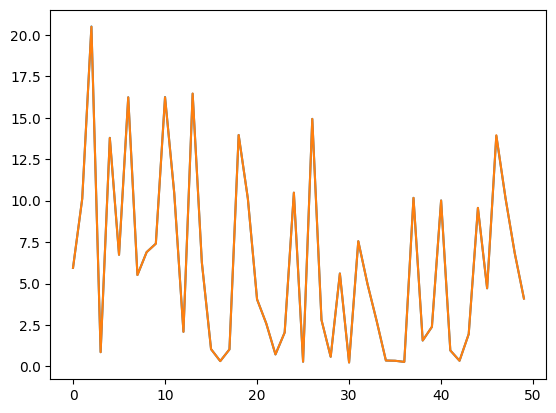

In [15]:
plt.plot(pred_y[-50:])
plt.plot(true_y[-50:])

In [52]:
l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, test_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


Adv_synthetic : L1 loss: 1.25994 	 L2 Loss : 4.36679 	 MAPE loss : 0.01515 


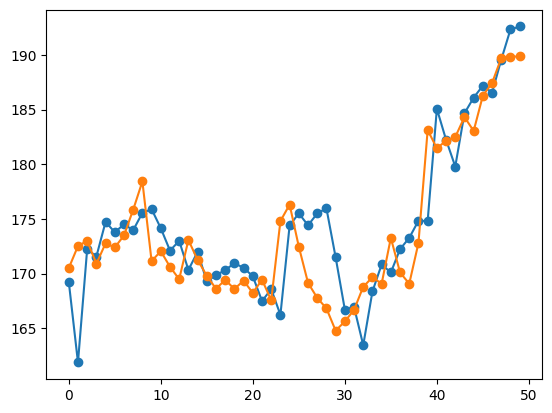

In [17]:
plt.plot(pred_y[-50:], marker="o")
plt.plot(true_y[-50:], marker="o")

In [18]:
for _ in range(10):
    idx = np.random.permutation(len(gt_data))[:1000]
    fake_data = diffusion_ts.generate_mts(batch_size=2000)
    syn_data = np.concatenate([gt_data[idx], fake_data])
    syn_dl = DataLoader(syn_data, batch_size=batch_size, shuffle=True)
    train_model(gt_predictor, syn_dl,lossfn,gt_optimizer, 2000)
    l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, test_loader)
    print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")



reverse step from x_T to x_0:   0%|          | 0/100 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
 loss: 0.014099: 100%|██████████| 2000/2000 [00:43<00:00, 45.82it/s]


Adv_synthetic : L1 loss: 1.24366 	 L2 Loss : 4.20438 	 MAPE loss : 0.01497 


 loss: 0.014646: 100%|██████████| 2000/2000 [00:43<00:00, 45.72it/s]


Adv_synthetic : L1 loss: 1.26747 	 L2 Loss : 4.42387 	 MAPE loss : 0.01516 


 loss: 0.017493: 100%|██████████| 2000/2000 [00:44<00:00, 45.24it/s]


Adv_synthetic : L1 loss: 1.27052 	 L2 Loss : 4.40563 	 MAPE loss : 0.01523 


 loss: 0.017379: 100%|██████████| 2000/2000 [00:43<00:00, 46.01it/s]


Adv_synthetic : L1 loss: 1.25994 	 L2 Loss : 4.36679 	 MAPE loss : 0.01515 


reverse step from x_T to x_0:  55%|█████▌    | 55/100 [00:23<00:19,  2.36it/s]


KeyboardInterrupt: 

Adv_synthetic : L1 loss: 1.35900 	 L2 Loss : 4.97446 	 MAPE loss : 0.01662 

In [ ]:
gt_predictor = GRU(5, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)

train_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, num_epochs=3000)
l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, train_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


 loss: 0.020209: 100%|██████████| 3000/3000 [01:14<00:00, 40.32it/s]


Adv_synthetic : L1 loss: 0.07281 	 L2 Loss : 0.01895 	 MAPE loss : 0.02449 


In [ ]:
for _ in range(10):
    train_model(gt_predictor, dl_info["dataloader"], lossfn, gt_optimizer, 2000)
    l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, test_loader)
    print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")



 loss: 0.016017: 100%|██████████| 2000/2000 [00:49<00:00, 40.35it/s]


Adv_synthetic : L1 loss: 2.24388 	 L2 Loss : 13.90903 	 MAPE loss : 0.02679 


 loss: 0.012482: 100%|██████████| 2000/2000 [00:49<00:00, 40.22it/s]


Adv_synthetic : L1 loss: 2.23068 	 L2 Loss : 13.79343 	 MAPE loss : 0.02663 


 loss: 0.012841: 100%|██████████| 2000/2000 [00:49<00:00, 40.21it/s]


Adv_synthetic : L1 loss: 2.21945 	 L2 Loss : 13.69036 	 MAPE loss : 0.02647 


 loss: 0.012440: 100%|██████████| 2000/2000 [00:50<00:00, 39.84it/s]


Adv_synthetic : L1 loss: 2.22640 	 L2 Loss : 13.70218 	 MAPE loss : 0.02652 


 loss: 0.013755:  11%|█         | 219/2000 [00:05<00:45, 38.78it/s]


KeyboardInterrupt: 

In [ ]:
gt_predictor = GRU(5, 50, 1, 2).to(device)
gt_optimizer = Adam(gt_predictor.parameters(), lr=0.001)

train_model(gt_predictor, dl_info["dataloader"],lossfn, gt_optimizer, num_epochs=3000)
l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, train_loader)
print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")


 loss: 0.018968: 100%|██████████| 3000/3000 [01:13<00:00, 40.73it/s]


Adv_synthetic : L1 loss: 0.07333 	 L2 Loss : 0.01917 	 MAPE loss : 0.02454 


In [ ]:
for _ in range(10):
    fake_data = diffusion_ts.generate_mts(batch_size=3000)
    syn_dl = DataLoader(fake_data, batch_size=batch_size, shuffle=True)
    train_model(gt_predictor, syn_dl,lossfn,gt_optimizer, 2000)
    l1, l2, mape, pred_y, true_y = evaluate_model(gt_predictor, test_loader)
    print(f"Adv_synthetic : L1 loss: {l1:0.5f} \t L2 Loss : {l2:0.5f} \t MAPE loss : {mape:0.5f} ")



 loss: 0.014580: 100%|██████████| 2000/2000 [00:43<00:00, 46.19it/s]


Adv_synthetic : L1 loss: 2.16471 	 L2 Loss : 13.11437 	 MAPE loss : 0.02598 


 loss: 0.016434: 100%|██████████| 2000/2000 [00:43<00:00, 46.27it/s]


Adv_synthetic : L1 loss: 2.18899 	 L2 Loss : 13.33519 	 MAPE loss : 0.02628 


 loss: 0.018237: 100%|██████████| 2000/2000 [00:43<00:00, 45.77it/s]


Adv_synthetic : L1 loss: 2.18369 	 L2 Loss : 13.25849 	 MAPE loss : 0.02605 


 loss: 0.021895: 100%|██████████| 2000/2000 [00:43<00:00, 45.77it/s]


Adv_synthetic : L1 loss: 2.21217 	 L2 Loss : 13.54535 	 MAPE loss : 0.02640 


 loss: 0.015441: 100%|██████████| 2000/2000 [00:43<00:00, 46.44it/s]


Adv_synthetic : L1 loss: 2.18635 	 L2 Loss : 13.14626 	 MAPE loss : 0.02622 


reverse step from x_T to x_0:   1%|          | 1/100 [00:00<01:26,  1.15it/s]


KeyboardInterrupt: 